In [22]:
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
nybb = gpd.read_file(gpd.datasets.get_path('nybb')).to_crs(epsg=4326)

def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

/home/baneckik/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


# Nowe stacje pojawiające się w każdym miesiącu

Poniższy kod wykonuje się parę minut(u mnie 4). Tworzy ramkę danych `stations` ze wszystkimi stacjami oraz ramkę `new_stations` ze stacjami dodanymi w danym miesiącu.

In [3]:
# wgrywamy pierwszy miesiąc
data_folder = 'data'
data_file_sample = '201701-citibike-tripdata'
data_path = os.path.join(os.getcwd(), data_folder, data_file_sample+'.csv.zip')
zf = zipfile.ZipFile(data_path)
data_sample = pd.read_csv(zf.open(data_file_sample+'.csv'))
data_sample.columns = map(str.lower, data_sample.columns)

# tworzymy pierwszy zbiór stacji
stations = pd.merge(data_sample.iloc[:,3:7].drop_duplicates(),data_sample.iloc[:,7:11].drop_duplicates(),how="outer",
         left_on=["start station id","start station name","start station latitude","start station longitude"],
        right_on=["end station id","end station name","end station latitude","end station longitude"])
stations = stations.iloc[:,0:4]
stations.columns = ["id","name","latitude","longitude"]
stations = stations.dropna()

# tworzymy wektor wktórym będziemy przechowywać nowe stacje w każdym miesiącu
new_stations = pd.DataFrame(columns=["year","month","station"])
index = 0

for year in range(2017,2020):
    if year==2017:
        Min_month=2
    else:
        Min_month=1
    if year==2019:
        Max_month=12
    else:
        Max_month=13
    for month in range(Min_month,Max_month):
        # otwieramy nowy plik
        data_file_sample = str(year)
        if month<10:
            data_file_sample += '0'
        data_file_sample += str(month)+'-citibike-tripdata'
        data_path = os.path.join(os.getcwd(), data_folder, data_file_sample+'.csv.zip')
        zf = zipfile.ZipFile(data_path)
        data_sample = pd.read_csv(zf.open(data_file_sample+'.csv'))
        data_sample.columns = map(str.lower, data_sample.columns)

        # tworzymy drugi zbiór stacji
        stations2 = pd.merge(data_sample.iloc[:,3:7].drop_duplicates(),data_sample.iloc[:,7:11].drop_duplicates(),how="outer",
                 left_on=["start station id","start station name","start station latitude","start station longitude"],
                right_on=["end station id","end station name","end station latitude","end station longitude"])
        stations2 = stations2.iloc[:,0:4]
        stations2.columns = ["id","name","latitude","longitude"]
        stations2 = stations2.dropna()

        # dodajemy nowe stacje
        new = Diff(stations2.id, stations.id)
        for i in range(len(new)):
            new_stations.loc[index] = [year,month,new[i]]
            index += 1

        # uaktualniamy nasze stacje
        stations = stations.merge(stations2,how="outer",on=["id","name","latitude","longitude"])

In [12]:
print(stations.shape,new_stations.shape)
# 1050 stacji wgle, 402 stacje których nie było od początku

(1050, 4) (402, 3)


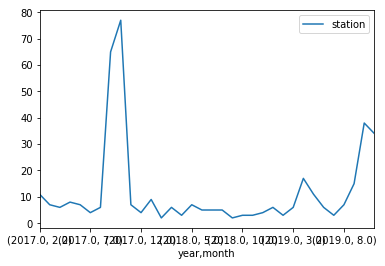

In [21]:
# dodawanie nowych stacji na przestrzeni czasu
new_stations.groupby(["year","month"]).count().plot()

In [28]:
new_stations.head()

,year,month,station,day
0,2017.0,2.0,3130.0,2017-02-01
1,2017.0,2.0,3337.0,2017-02-01
2,2017.0,2.0,462.0,2017-02-01
3,2017.0,2.0,3450.0,2017-02-01
4,2017.0,2.0,3445.0,2017-02-01


In [33]:
new_stations["day"] = [1 for i in range(new_stations.shape[0])]
new_stations["day"] = pd.to_datetime(new_stations[["year","month", "day"]])

In [30]:
new_stations = new_stations.merge(stations,how="left",left_on="station",right_on="id")

In [34]:
new_stations.head()

,year,month,station,day,id,name,latitude,longitude
0,2017.0,2.0,3130.0,2017-02-01,3130.0,21 St & Queens Plaza North,40.753260,-73.943358
1,2017.0,2.0,3337.0,2017-02-01,3337.0,Dwight St & Van Dyke St,40.673636,-74.011956
2,2017.0,2.0,462.0,2017-02-01,462.0,W 22 St & 10 Ave,40.746920,-74.004519
3,2017.0,2.0,3450.0,2017-02-01,3450.0,Penn Station Valet - Valet Scan,40.751284,-73.996925
4,2017.0,2.0,3445.0,2017-02-01,3445.0,Riverside Dr & W 89 St,40.791812,-73.978602


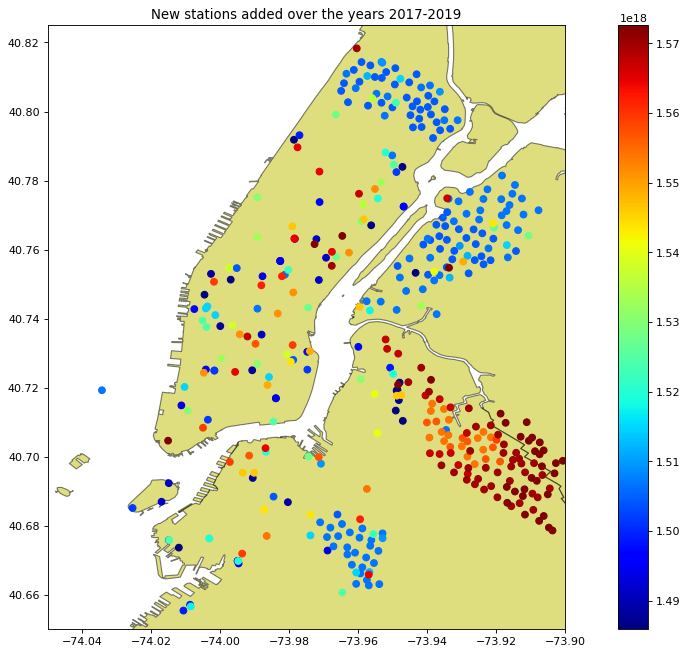

In [35]:
fig, ax = plt.subplots(figsize=(17, 10), dpi= 80, facecolor='w', edgecolor='none')
nybb.plot(ax=ax, figsize=(10, 10), alpha=0.5, edgecolor='k',color='y')
ax.set_ylim(40.65,40.825)
ax.set_xlim(-74.05,-73.9)
ax.title.set_text('New stations added over the years 2017-2019')

sc = ax.scatter(x=new_stations["longitude"],y=new_stations["latitude"],\
                                     c=new_stations["day"], cmap=plt.get_cmap('jet'),\
               )#vmin=-1000,vmax=2000)

plt.colorbar(sc, ax=ax)

Na niebiesko są stacje, które zostały włączone do systemu jeszcze w 2017 roku (patrz wykres powyżej) a na czerwono i pomarańczowo stacje włączone w 2019.